#**Predict LOS using LSTM & CNN**

This solution is designed to predict Length of Stay (LOS) of each patient, at time of admission, in hospital using LSTM & Convolution Neural Network. There can be significant variation of LOS as per various facilities, disease conditions and specialties even within the same healthcare system. Advanced LOS prediction at the time of admission can greatly enhance the quality of care as well as operational workload efficiency. Also greatly help with accurate planning for discharges resulting in lowering of various other quality measures such as readmissions.

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients. This dataset consists of numeric as well as categorical features. Before feeding the data to model and predict the LOS;we will process the numeric data further to extract features & convert categorical data to numbers. 
This can be achieved with a few steps as listed below -
- Pre-process categorical features using:
    1. One Hot Encoding
    2. Label Encoding
    3. Tokenizer
- Pre-process numeric data using convolution Neural Network for extracting features.
- Concatenate all inputs using a dictionary.
- Pass this concatenated input to Keras Model.
- Compile the model
- Build the Model

<font color=blue size = 4.8>Import necessary libraries</font>

In [1]:
# Importing Data manipulation and plotting modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pydot
from skimage import io

In [2]:
# Import Keras Libraries
from keras.layers import Input, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten,Embedding, GRU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
# Import library for keras plotting model
from keras.utils import  plot_model

In [4]:
# Import sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [5]:
# Importing Miscelaneous libraries
import os
import time

<font color=blue size = 4.8>Loading dataset</font>

In [6]:
pathToData = '../input/'
os.chdir(pathToData)
# 2.2
data = pd.read_csv('../input/mimic3d/mimic3d.csv',
	               compression='infer',
                   encoding="ISO-8859-1"      # 'utf-8' gives error, hence the choice
                  )


# 2.3 Inspect the data
data.shape            # (58976, 28)

(58976, 28)

<font color=blue size = 4.8>Dropping redundant columns & filling in missing cells</font>

In [7]:
# Drop first column: 'hadm_id', being id column
data.drop(['hadm_id'], axis = 'columns' , inplace = True)


# Check for missing values
data.isnull().values.sum()        # 10611

# Check which columns have missing values
data.columns[data.isnull().sum()  > 0]    # Three: Index(['AdmitDiagnosis', 'religion', 'marital_status'], dtype='object')

# Let us follow a conservative and safe approach to fill missing values
data.AdmitDiagnosis = data.AdmitDiagnosis.fillna("missing")
data.religion = data.religion.fillna("missing")
data.marital_status = data.marital_status.fillna("missing")
data.isnull().values.sum()  

0

Text(0.5, 1.0, 'Patient Age Distribution')

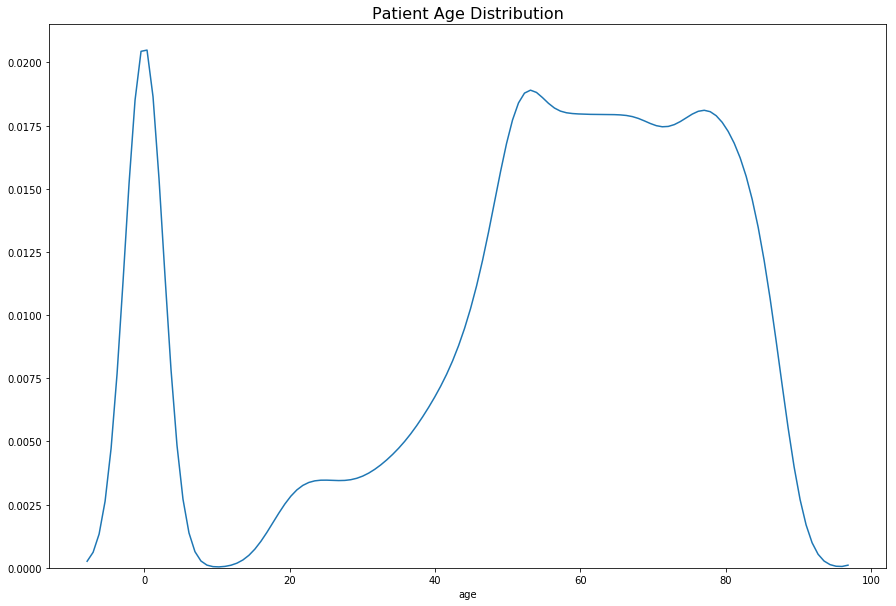

In [8]:
plt.figure(figsize=(15,10))
sns.distplot(data['age'],hist=False)
plt.title('Patient Age Distribution',fontsize=16)

Text(0.5, 1.0, 'Patient Length Of stay Distribution')

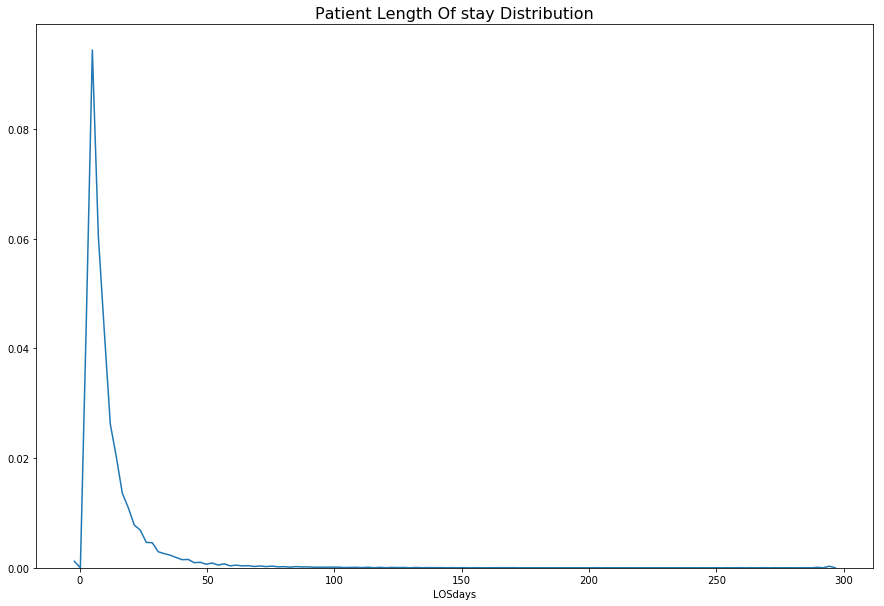

In [9]:
plt.figure(figsize=(15,10))
sns.distplot(data['LOSdays'],hist=False)
plt.title('Patient Length Of stay Distribution',fontsize=16)

<font color=blue size = 4.8>Split data into -</font>
1. Train & Test
2. Categorical & Numeric

In [10]:
# Divide data into train/test
dtrain,  dtest = train_test_split(data, test_size=0.33)


# Check which columns are 'object'
obj_columns = data.select_dtypes(include = ['object']).columns.values
obj_columns


array(['gender', 'admit_type', 'admit_location', 'AdmitDiagnosis',
       'insurance', 'religion', 'marital_status', 'ethnicity',
       'AdmitProcedure'], dtype=object)

In [11]:
# Check which columns have numeric data
num = data.select_dtypes(include = ['int64', 'float64']).columns.values
num

"""
array(['age', 'LOSdays', 'NumCallouts', 'NumDiagnosis', 'NumProcs',
       'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes',
       'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract',
       'LOSgroupNum'], dtype=object)

IInd column is target
And columns 'ExpiredHospital', 'LOSgroupNum' are categorical. See below

"""



"\narray(['age', 'LOSdays', 'NumCallouts', 'NumDiagnosis', 'NumProcs',\n       'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes',\n       'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',\n       'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract',\n       'LOSgroupNum'], dtype=object)\n\nIInd column is target\nAnd columns 'ExpiredHospital', 'LOSgroupNum' are categorical. See below\n\n"

In [12]:
# Levels in columns: 'ExpiredHospital', 'LOSgroupNum'
data.LOSgroupNum.value_counts()          # 4 levels
data.ExpiredHospital.value_counts()      # 2 levels

0    53122
1     5854
Name: ExpiredHospital, dtype: int64

#**Pre-process categorical features**

<font color=blue size = 4.8>Check number of levels in each categorical column</font>

gender 2


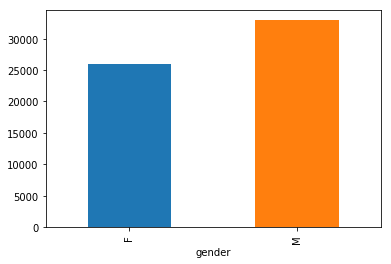

admit_type 4


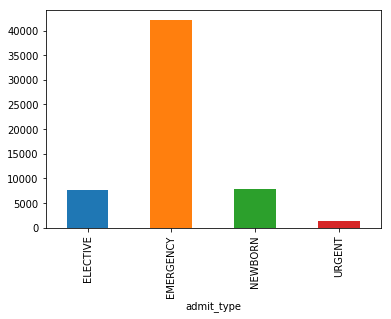

admit_location 9


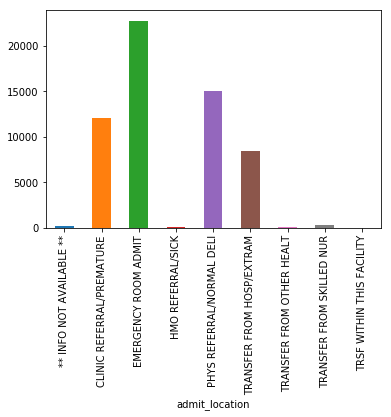

AdmitDiagnosis 15692
insurance 5


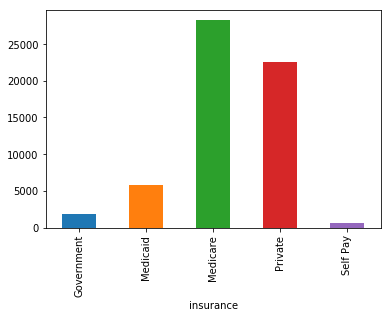

religion 21


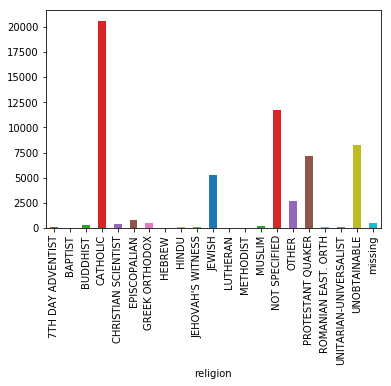

marital_status 8


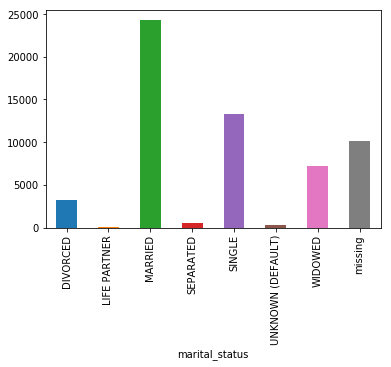

ethnicity 41
AdmitProcedure 1277


In [13]:
for i in obj_columns:
    print(i,len(data[i].value_counts()))
    if(len(data[i].value_counts())<25):
        data.groupby(data[i]).size().plot.bar()
        plt.show()

Text(0, 0.5, 'Admit Type')

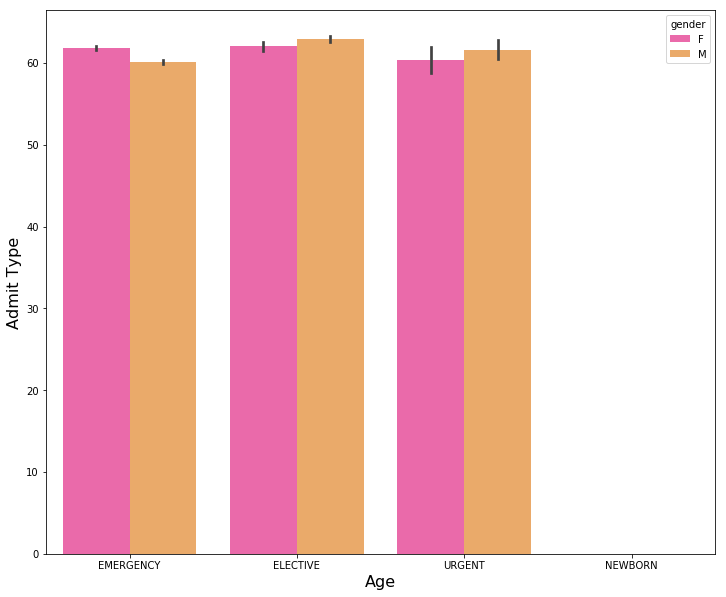

In [14]:
plt.figure(figsize=(12,10))
sns.barplot(x=data.admit_type, y=data.age,data=data, hue=data.gender,palette='spring')
plt.xlabel('Age',fontsize=16)
plt.ylabel('Admit Type',fontsize=16)

<font color=blue size = 3>One Hot Encoding list of categorical columns having levels < 10 (mentioned in below array 'obj_cols')</font>

In [15]:
# 4.4 Final seven obj_columns for One Hot Encoding
obj_cols = ["gender", "admit_type", "admit_location", "insurance" ,"marital_status", 'ExpiredHospital', 'LOSgroupNum']
ohe = OneHotEncoder()
# 4.4.1 Traing on dtrain
ohe = ohe.fit(dtrain[obj_cols])
# 4.4.2 Transform train (dtrain) and test (dtest) data
dtrain_ohe = ohe.transform(dtrain[obj_cols])
dtest_ohe = ohe.transform(dtest[obj_cols])
# 4.4.3
dtrain_ohe.shape       # (39513, 34)
dtest_ohe.shape        # (19463, 34)

(19463, 34)

<font color=blue size = 3>Label Encoding list of categorical columns having levels < 100</font>

In [16]:

# 5.0 Label encode relegion and ethnicity
# 5.1 First 'religion'

le = LabelEncoder()
le.fit(data["religion"])                           # Train on full data else some labels may be absent in test data
dtrain["re"] = le.transform(dtrain['religion'])    # Create new column in dtrain
dtest["re"] = le.transform(dtest['religion'])      #   and in dtest

# 5.2 Now 'ethnicity'
le = LabelEncoder()
le.fit(data["ethnicity"])                          # train on full data
dtrain["eth"]= le.transform(dtrain['ethnicity'])   # Create new column in dtrain
dtest["eth"]= le.transform(dtest['ethnicity'])     #   and in dtest



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

<font color=blue size = 3>Tokenizing list of categorical columns having levels > 100</font>

In [17]:

# 6. Finally transform two obj_columns for tokenization
te_ad = Tokenizer()
# 6.1 Train tokenizer on train data ie 'dtrain'
te_ad.fit_on_texts(data.AdmitDiagnosis.values)
# 6.2 Transform both dtrain and dtest and create new columns
dtrain["ad"] = te_ad.texts_to_sequences(dtrain.AdmitDiagnosis)
dtest["ad"] = te_ad.texts_to_sequences(dtest.AdmitDiagnosis)

dtrain.shape
dtest.shape

# 6.3 Similarly for column: AdmitProcedure
te_ap = Tokenizer(oov_token='<unk>')
te_ap.fit_on_texts(data.AdmitProcedure.values)
dtrain["ap"] = te_ap.texts_to_sequences(dtrain.AdmitProcedure)
dtest["ap"] = te_ap.texts_to_sequences(dtest.AdmitProcedure)

dtrain.shape
dtest.shape



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

(19463, 31)

<font color=blue size = 3>Get max length of the sequences</font>

In [18]:
# dtrain["ad"], dtest["ad"]

maxlen_ad = 0
for i in dtrain["ad"]:
	if maxlen_ad < len(i):
		maxlen_ad = len(i)

for i in dtest["ad"]:
	if maxlen_ad < len(i):
		maxlen_ad = len(i)

maxlen_ad



24

In [19]:
# dtrain["ap"], dtest["ap"]

maxlen_ap = 0
for i in dtrain["ap"]:
	if maxlen_ap < len(i):
		maxlen_ap = len(i)

for i in dtest["ap"]:
	if maxlen_ap < len(i):
		maxlen_ap = len(i)

maxlen_ap


7

<font color=blue size = 3>Get max vocabulary size i.e value of highest integer for categorical features</font>

In [20]:
# in dtrain["ad"] and in dtest["ad"]

one = np.max([np.max(i) for i in dtrain["ad"].tolist() ])
two = np.max([np.max(i) for i in dtest["ad"].tolist() ])
MAX_VOCAB_AD = np.max([one,two])

# in dtrain["ap"] and in dtest["ap"]

one = np.max([np.max(i) for i in dtrain["ap"].tolist() ])
two = np.max([np.max(i) for i in dtest["ap"].tolist() ])
MAX_VOCAB_AP = np.max([one,two])

# 
MAX_VOCAB_RE = len(dtrain.religion.value_counts())
MAX_VOCAB_ETH = len(dtrain.ethnicity.value_counts())


#**Pre-process numeric data 'num'**

<font color=blue size = 3>Excluding 'LOSdays' since it is target</font>

In [21]:
num = ['age', 'NumCallouts', 'NumDiagnosis', 'NumProcs',
       'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes',
       'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers',
       'NumChartEvents', 'TotalNumInteract']

In [22]:
# Standardize numerical data
se = StandardScaler()
# Train on dtrain
se.fit(dtrain.loc[:,num])


StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
# Then transform both dtrain and dtest
dtrain[num] = se.transform(dtrain[num])
dtest[num] = se.transform(dtest[num])
dtest.loc[:,num].head(3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

,age,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,TotalNumInteract
29063,0.078140,-0.178724,-0.261907,0.066222,0.184814,-0.053721,-0.342507,-0.176140,-0.055952,0.931174,-0.103154,0.135177,-0.240783,0.339831,0.244031
37191,0.193094,-0.607730,1.078243,0.644750,3.109187,0.336019,1.445714,0.667944,-0.016841,1.671348,0.773815,-0.317759,0.024990,2.084667,1.954252
32326,-0.036815,-0.607730,-0.256812,0.108188,-0.469551,0.642491,0.049154,-0.283104,-0.057211,2.326219,0.138856,-0.317759,-0.145864,-0.153387,-0.062895


In [24]:
# Reshape train num data
dtrain[num].values.shape
dtr_reshape = dtrain[num].values.reshape(39513,15,1)

In [25]:
# Reshape test num data
dtest[num].values.shape
dts_reshape = dtest[num].values.reshape(19463,15,1)

#**Concatenate all inputs using a dictionary**

In [26]:
# Training data
Xtr = {
	"num" : dtr_reshape,          # Note the name 'num'
	"ohe" : dtrain_ohe.toarray(),        # Note the name 'ohe'
	"re"  : dtrain["re"].values,
	"eth" : dtrain["eth"].values,
	"ad"  : pad_sequences(dtrain.ad, maxlen=maxlen_ad),
	"ap"  : pad_sequences(dtrain.ap, maxlen=maxlen_ap )
      }

In [27]:
# Test data
Xte = {
	"num" : dts_reshape,
	"ohe" : dtest_ohe.toarray(),
	"re"  : dtest["re"].values,
	"eth" : dtest["eth"].values,
	"ad"  : pad_sequences(dtest.ad, maxlen=maxlen_ad ),
	"ap"  : pad_sequences(dtest.ap, maxlen=maxlen_ap )
      }

In [28]:
# Just check shapes.
# Total data features are now: 15 + 34 + 24 + 7 + 1 +1 = 82
# Embeddings have thus generated new features.
Xtr["num"].shape         # (39513, 15)
Xtr["ohe"].shape         # (39513, 34)
Xtr["ad"].shape          # (39513, 24)
Xtr["ap"].shape          # (39513, 7)
Xtr["re"].shape          # (39513,)  1D
Xtr["eth"].shape         # (39513,)  1D

(39513,)

#**Pass this concatenated input to Keras Model**

In [29]:
# Design a simple model now

dr_level = 0.1

# 11.1
num = Input(
                      shape= (Xtr["num"].shape[1], 1 ),
					  name = "num"            # Name 'num' should be a key in the dictionary for numpy array input
					                          #    That is, this name should be the same as that of key in the dictionary
					  )

# 11.2
ohe =   Input(
                      shape= (Xtr["ohe"].shape[1], ),
					  name = "ohe"
					  )

# 11.3
re =   Input(
                      shape= [1],  # 1D shape or one feature
					  name = "re"
					  )
# 11.4
eth =   Input(
                      shape= [1],  # 1D shape or one feature
					  name = "eth"
					  )
# 11.5
ad =   Input(
                      shape= (Xtr["ad"].shape[1], ),
					  name = "ad"
					  )
# 11.6
ap =   Input(
                      shape= (Xtr["ap"].shape[1],),
					  name = "ap"
					  )


#**Mapping categorical levels to an embedding space**

In [30]:
# Embedding layers for each of the two of the columns with sequence data
emb_ad  =      Embedding(MAX_VOCAB_AD+ 1 ,      32  )(ad )
emb_ap  =      Embedding(MAX_VOCAB_AP+ 1 ,      32  )(ap)

# Embedding layers for the two categorical variables
emb_re  =      Embedding(MAX_VOCAB_RE+ 1 ,      32  )(re)
emb_eth =      Embedding(MAX_VOCAB_ETH+ 1 ,      32  )(eth)

# GRU layers for sequences
gru_ad = GRU(16) (emb_ad)          # Output of GRU is a vector of size 8
gru_ap = GRU(16) (emb_ap)

#**Processing numeric data using Convolution network**

In [31]:
conv_out = Conv1D(32, kernel_size=2, activation='relu')(num)
mp_num = MaxPooling1D(pool_size=2)(conv_out)
num_x = Flatten()(mp_num)
num_in = Flatten()(num)
num_final = concatenate([num_in,num_x])

#**Creating a model with 6 inputs and concatenating 6 respective outputs in a Dense layer**

In [32]:
model = Model([num, ohe, re, eth, ad,ap], [gru_ad, gru_ap, emb_re, emb_eth, num_final, ohe])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                (None, 15, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 14, 32)       96          num[0][0]                        
__________________________________________________________________________________________________
ad (InputLayer)                 (None, 24)           0                                            
__________________________________________________________________________________________________
ap (InputLayer)                 (None, 7)            0                                            
__________________________________________________________________________________________________
max_poolin

In [33]:
# Concatenate all outputs
class_l = concatenate([
                      gru_ad,              # GRU output is already 1D
                      gru_ap,
                      num_final,           # 1D output. No need to flatten. Observe model summary
                      ohe,                 # 1D output
                      Flatten()(emb_re),   # Need to flatten. Observe model summary above
                      Flatten()(emb_eth)
                      ]
                     )

In [34]:
# Add classification layer
class_l = Dense(64) (class_l)
class_l = Dropout(0.1)(class_l)
class_l = Dense(32) (class_l)
class_l = Dropout(0.1) (class_l)

In [35]:
# Output neuron. Activation is linear as our output is continous
output = Dense(1, activation="linear") (class_l)


In [36]:
# Formulate Model now
model = Model(
              inputs= [num, ohe, re, eth, ad, ap],
              outputs= output
             )


In [37]:
# 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                (None, 15, 1)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 14, 32)       96          num[0][0]                        
__________________________________________________________________________________________________
ad (InputLayer)                 (None, 24)           0                                            
__________________________________________________________________________________________________
ap (InputLayer)                 (None, 7)            0                                            
__________________________________________________________________________________________________
max_poolin

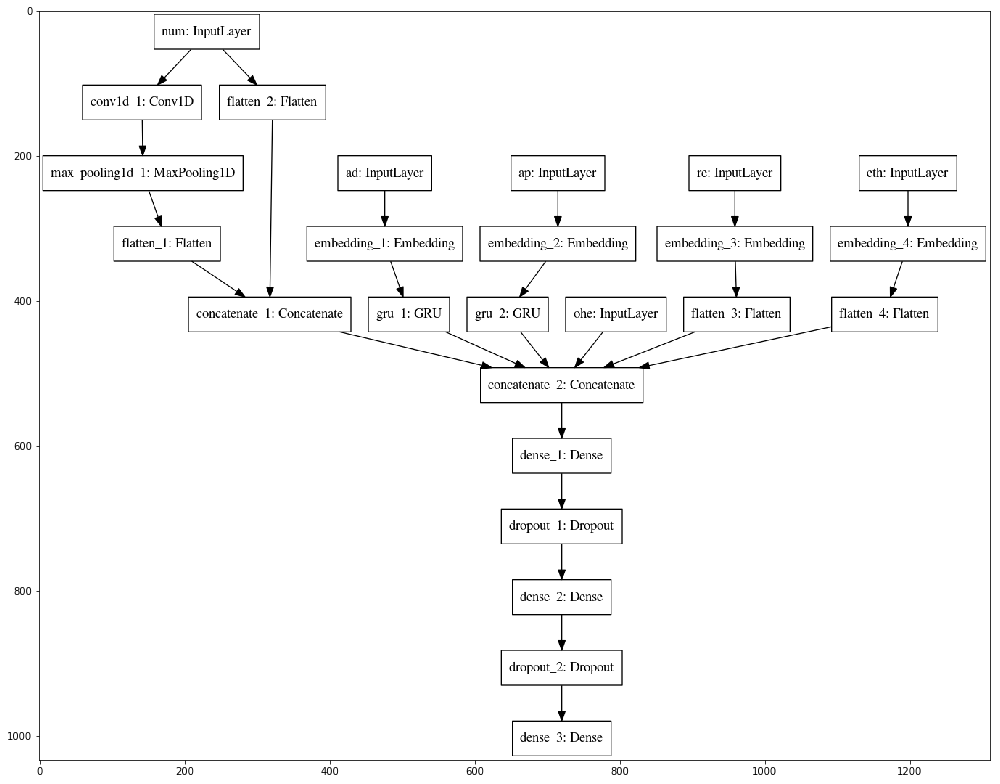

In [38]:
# Model plot uisng keras plot_model()
plt.figure(figsize = (14,14))
plot_model(model, to_file = "model.png")
io.imshow("model.png")

<font color=green>As we can see there are 6 inputs: Numeric (num), One hot encoded features ("gender", "admit_type", "admit_location", "insurance" ,"marital_status", "ExpiredHospital", "LOSgroupNum"), Religion (re), Ethnicity (eth), Admit Diagnosis (ad) and Admit procedure (ap). Their corresponding 6 outputs are concatenated and passed to a Dense Classification layer. This model will minimize the Mean Sqare Error (mse) significantly.</font>

#**Compile Model**

In [39]:
# Compile model
model.compile(loss="mse",
              optimizer="adam",
              metrics=["mae"]
			  )

In [40]:
# 13.1
BATCH_SIZE = 5000
epochs = 20

#**Fitting model on Validation data**

In [41]:

# 
start = time.time()
history= model.fit(Xtr,
                   dtrain.LOSdays,
                   epochs=epochs,
                   batch_size=BATCH_SIZE,
				   validation_data=(Xte, dtest.LOSdays),
				   verbose = 1
                  )
end = time.time()
print((end-start)/60)

Train on 39513 samples, validate on 19463 samples
Epoch 1/20
39513/39513 [==============================] - 4s 97us/step - loss: 228.3001 - mean_absolute_error: 9.0602 - val_loss: 216.5196 - val_mean_absolute_error: 7.8698
Epoch 2/20
39513/39513 [==============================] - 2s 42us/step - loss: 180.5411 - mean_absolute_error: 7.1188 - val_loss: 170.5833 - val_mean_absolute_error: 6.6495
Epoch 3/20
39513/39513 [==============================] - 2s 42us/step - loss: 145.2826 - mean_absolute_error: 6.7965 - val_loss: 151.6118 - val_mean_absolute_error: 7.3164
Epoch 4/20
39513/39513 [==============================] - 2s 42us/step - loss: 139.2160 - mean_absolute_error: 7.2722 - val_loss: 146.2256 - val_mean_absolute_error: 6.8558
Epoch 5/20
39513/39513 [==============================] - 2s 42us/step - loss: 130.7953 - mean_absolute_error: 6.4286 - val_loss: 139.8477 - val_mean_absolute_error: 6.0909
Epoch 6/20
39513/39513 [==============================] - 2s 42us/step - loss: 125.23